In [51]:
import random
import operator
import math
import numpy as np
from deap import creator, base, tools, algorithms,gp
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [14]:
pset = gp.PrimitiveSet("MAIN", 1)

In [15]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [16]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [17]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [18]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [40]:
expr = gp.genFull(pset, min_=1, max_=3)
tree = gp.PrimitiveTree(expr)
str(tree)

'mul(sin(mul(ARG0, 1)), sub(protectedDiv(ARG0, ARG0), protectedDiv(ARG0, ARG0)))'

In [49]:
expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)

In [58]:
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

print(g.nodes())
# pos = nx.graphviz_layout(g, prog="dot")

# nx.draw_networkx_nodes(g, pos)
# nx.draw_networkx_edges(g, pos)
# nx.draw_networkx_labels(g, pos, labels)
# plt.show()

[0, 1, 2, 3, 4, 5]


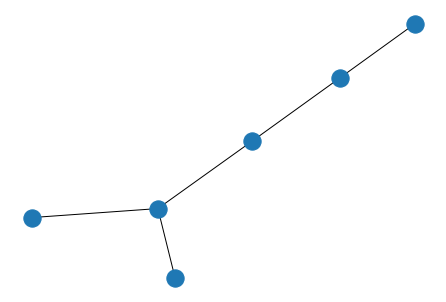

In [60]:
nx.draw(g)
#plt.savefig("simple_path.png") # save as png
plt.show() # display


In [33]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

In [20]:
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [25]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [26]:
pop = toolbox.population(n=300)

In [27]:
hof = tools.HallOfFame(1)

In [28]:
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)

   	      	                        fitness                        	                     size                     
   	      	-------------------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg 	gen	max	min	nevals	std   
0  	300   	5.72634	0  	1080.77	0.165572	300   	62.3045	3.58	0  	7  	2  	300   	1.4867
1  	169   	1.25574	1  	14.2339	0.165572	169   	1.62287	3.82667	1  	9  	1  	169   	1.6114
2  	160   	0.948164	2  	6.85956	0.165572	160   	0.735051	3.89667	2  	9  	1  	160   	1.61431
3  	172   	0.916662	3  	11.1136	0.101561	172   	1.04345 	4.32667	3  	9  	1  	172   	1.7795 
4  	165   	0.86923 	4  	14.1201	0.101561	165   	0.977115	4.66   	4  	11 	1  	165   	1.98605
5  	153   	0.71204 	5  	6.85956	0.101561	153   	0.696858	5.08667	5  	11 	1  	153   	1.95938
6  	158   	0.752486	6  	21.1252	0.0517429	158   	1.38408 	5.91333	6  	13 	1  	158   	2.03121
7  	142   	0.563512	7  	4.79275	0.0517429	142   	0